Você foi contratado para criar um sistema que realiza a classificação de imagens de frutas para uma empresa de e-commerce. O objetivo é que, ao enviar uma imagem, o sistema identifique se a fruta é uma maçã, uma banana ou uma laranja. Sabendo que você possui um banco de imagens já categorizado, explique quais tipos de redes neurais você utilizaria para resolver esse problema, como seria o processo de implementação utilizando Python e quais etapas principais precisam ser seguidas para treinar o modelo.
Padrão de Resposta para a Atividade:

- Indicação clara do tipo de rede neural usada e justificativa do porquê de ser a escolha mais adequada;
- Descrição do processo de pré-processamento das imagens;
- Apresentação do modelo de rede neural em Python, com uma breve explicação de cada camada;
- Compilação e treinamento do modelo, mencionando a função de perda e o otimizador usados;
- Processo de avaliação e validação do modelo;
- Conclusão explicando como o modelo resolverá o problema proposto.

## Oficina 2: Sistema de classificação de imagens

## 1. Introdução

O objetivo do projeto é criar um sistema capaz de receber uma imagem de uma fruta e retornar a sua classificação como sendo uma maça, banana ou laranja, para isso é necessário criar um modelo de aprendizado supervisionado capaz de reconhecer caracteríticas das frutas pretendidas por meio de um banco de imagens pré-rotuladas.

### Bibliotecas


- **Seaborn**, biblioteca em python foi utilizada para gerar gráfico de comparação da acurácia ao longo das epochs.
- **Scikit-learn**, para clasular métricas de avaliação.
  - confusion_matrix: Matriz de confusão para análise de desempenho.
  - classification_report: Relatório com precisão, recall e F1-score.
- **Tensor-flow**, para o carregamento e tratamento dos dados utilizados na modelagem e para a criação, treinamento e avaliação de modelo de classificação.
- **Numpy**, para conversão de imagens em array multidimensionais.
- **TensorFlow**, para construção e treinamento de modelos de deep learning.
- **Keras** (tensorflow.keras), API de alto nível para redes neurais (integradas ao TensorFlow).
  - Sequential: Modelo sequencial para empilhar camadas.
  - layers: Camadas pré-definidas (ex: Conv2D, MaxPooling2D, Dense).
  - ImageDataGenerator: Pré-processamento e aumento de dados para imagens.

In [23]:

%pip install numpy tensorflow
%pip install matplotlib
%pip install scikit-learn

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import os



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 2. Compreensão dos Dados

A fonte de dados utilizado foi o dataset público disponível no Kaggle chamado [Fruits 360 Dataset (100x100)](https://www.kaggle.com/datasets/moltean/fruits/data?select=fruits-360_dataset_100x100), que contém divers imagens de frutas categorizados. Esse dataset foi escolhido, dentre outros semelhantes, pela enorme quantidade, qualidade e variedade de imagens, o que é ideal para o treinamento de um modelo de clssificação de imagens em que o algortimo precisa ter a oportunidade de entrar em contato com o máximo de características distintas do mesmo rótulo para conseguir generalizar bem com dados reais.

As imagens estão armazenadas em dois diretórios principais "teste" e "treinamento", em cada um dos diretórios as imagens estão dispostas nos subdiretórios  "Apple", "Banana" e "Orange" 

| Tipo de Imagem | Quantidade |     
|----------------|------------|
| Treinamento    | 7180      |
| Teste          | 3403       |
---
| Fruta   | Treinamento | Teste  |
|---------|-------------|-------|
| Apple   | 4569        | 2525  |
| Orange  | 1181        | 394   |
| Banana  | 1430        | 484   |



In [24]:
# O caminho para os diretórios de treinamento e teste são armazenados nas seguintes variáveis:
test_path = ("/home/adsr/Documentos/cjovem/Uece-C-Jovem/Ciência de Dados - Avançado/aux/360fruits/treinamento")
train_path = ("/home/adsr/Documentos/cjovem/Uece-C-Jovem/Ciência de Dados - Avançado/aux/360fruits/teste")


**Quantidade total em cada diretório.**

In [25]:
import os
def count_images_in_directory(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

train_count = count_images_in_directory(train_path)
test_count = count_images_in_directory(test_path)

print(f"Quantidade de imagem para Treinamento e Validação: {train_count}")
print(f"Quantidade de imagens para Teste: {test_count} \n")

Quantidade de imagem para Treinamento e Validação: 7180
Quantidade de imagens para Teste: 3403 



**Nota-se que a distribuição das quantidade de fotos entre as classes é desbalanceada. O rótulo Apple possui mais que o quádruplo de imagens que as classe Orange e Banana. Isso indica uma importante possibilidade de ocorrer overfitting no treinamento desse modelo**

In [26]:


# Calculate and display metrics for each subdirectory
def calculate_metrics(directory):
    metrics = {}
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            metrics[subdir] = count_images_in_directory(subdir_path)
    return metrics

train_metrics = calculate_metrics(train_path)
test_metrics = calculate_metrics(test_path)

print("Quantidade de imagens para Treinamento e Validação por fruta:")
for fruit, count in train_metrics.items():
    print(f"{fruit}: {count} images")
print("\n")
print("Quantidade de imagens para Teste por fruta:")
for fruit, count in test_metrics.items():
    print(f"{fruit}: {count} images")


Quantidade de imagens para Treinamento e Validação por fruta:
Banana: 1430 images
Apple: 4569 images
Orange: 1181 images


Quantidade de imagens para Teste por fruta:
Banana: 484 images
Apple: 2525 images
Orange: 394 images


**Exemplo de imagens que estão no diretório e sua respectivas classes:**

Found 7180 files belonging to 3 classes.


2025-02-26 00:25:50.811401: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


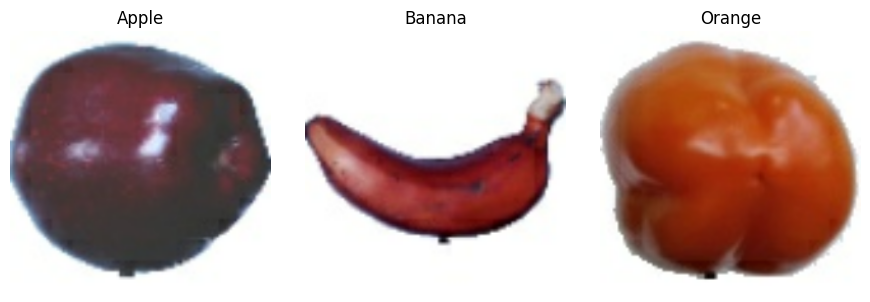

In [27]:
# Carregar os dados de treinamento
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
   
)

# Pegar uma amostra de cada classe
class_names = train_data.class_names
num_classes = len(class_names)
samples = [None] * num_classes

# Procurar uma imagem de cada classe
for images, labels in train_data:
    for img, lbl in zip(images, labels):
        lbl_idx = lbl.numpy()
        if samples[lbl_idx] is None:
            samples[lbl_idx] = img
    # Verificar se todas as classes foram encontradas
    if all(sample is not None for sample in samples):
        break

# Configurar a visualização
fig, axes = plt.subplots(1, num_classes, figsize=(num_classes * 3, 3))


# Mostrar uma imagem de cada classe
for i in range(num_classes):
    axes[i].imshow(samples[i].numpy().astype("uint8"))
    axes[i].set_title(class_names[i])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## 3. Preparação de dados

**Alguns parâmetros importantes são definidos e salvos para uso posterios.**

- **num_classes**: Sistema para identificar 3 classes diferentes de frutas
- **img_size**: Imagens redimensionadas para 100×100 pixels
- **batch_size**: Tamanho de cada lote de processamento
- **epochs**: Número de ciclos de treinamendo

In [28]:
img_size = (100, 100)
batch_size = 32
num_classes = 3
epochs = 20

**Este modelo utilizará técnicas de aumento de dados significativas para melhorar a generalização e o desempenho da classificação, mesmo com um conjunto de dados potencialmente limitado.**

Cada parâmetro do `ImageDataGenerator` tem um papel específico na criação de variações das imagens para treinamento do modelo:

- **rescale=1./255**: Normaliza os valores dos pixels, convertendo-os da faixa 0-255 para 0-1, facilitando o processamento pela rede neural.

- **rotation_range=40**: Aplica rotações aleatórias nas imagens de até 40 graus (positivos ou negativos), ajudando o modelo a reconhecer objetos em diferentes orientações.

- **width_shift_range=0.3**: Desloca horizontalmente as imagens em até 30% de sua largura, tornando o modelo mais robusto quanto à posição horizontal dos objetos.

- **height_shift_range=0.3**: Desloca verticalmente as imagens em até 30% de sua altura, tornando o modelo mais robusto quanto à posição vertical dos objetos.

- **shear_range=0.3**: Aplica transformações de cisalhamento (distorção angular) nas imagens, ajudando o modelo a lidar com diferentes perspectivas.

- **zoom_range=0.3**: Aplica zoom aleatório de aproximação ou afastamento em até 30%, permitindo que o modelo reconheça objetos em diferentes escalas.

- **horizontal_flip=True**: Inverte aleatoriamente as imagens horizontalmente, útil para reconhecimento de objetos que podem aparecer em ambas orientações.

- **vertical_flip=True**: Inverte aleatoriamente as imagens verticalmente, útil para reconhecimento de objetos que podem aparecer de cabeça para baixo.

- **brightness_range=[0.7, 1.3]**: Varia aleatoriamente o brilho das imagens entre 70% e 130% do original, tornando o modelo mais robusto a diferentes condições de iluminação.

- **validation_split=0.2**: Reserva 20% das imagens para validação, permitindo avaliar o desempenho do modelo durante o treinamento.



In [29]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

**Este código configura três geradores de dados para treinar e avaliar o modelo de classificação de imagens:**


- **train_generator:** Cria lotes de 32 imagens da pasta de treinamento, aplicando todas as transformações de aumento de dados definidas anteriormente. Usa 80% dos dados do diretório de treino (devido ao subset='training').

- **val_generator:** Gera dados de validação durante o treinamento, usando os 20% restantes das imagens do mesmo diretório de treino. Também aplica as mesmas transformações de aumento de dados.

- **test_generator:** Carrega imagens do diretório de teste para avaliação final do modelo, apenas redimensionando e normalizando-as (sem aumento de dados).
    A opção 'shuffle=False' mantém a ordem original das imagens para facilitar a análise dos resultados.

---
**Todos os geradores utilizam os parâmetros pré-definindos:**

- Redimensionam as imagens para 100×100 pixels
- Usam modo 'sparse' para codificar os rótulos como números inteiros (0, 1, 2)
- Carregam as imagens em lotes de 32 para processamento eficiente

In [30]:

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 5745 images belonging to 3 classes.
Found 1435 images belonging to 3 classes.
Found 3403 images belonging to 3 classes.


**class_weights é um dicionário que atribui diferentes pesos às classes durante o treinamento do modelo.**

- **Classe 0: Apple** Recebe peso 1.0 (parece ser a classe majoritária com 4569 amostras)

- **Classe 1: Banana** Recebe peso aproximadamente 3.2 (4569÷1430), compensando sua menor representação

- **Classe 2: Orange** Recebe peso aproximadamente 3.87 (4569÷1181), compensando sua menor representação


**Este balanceamento é importante porque:**

- Impede que o modelo favoreça a classe majoritária
- Força o modelo a prestar mais atenção às classes minoritárias
- Melhora o desempenho geral em conjuntos de dados desbalanceados

O valor de cada peso é calculado como a razão entre o número de amostras na classe majoritária (4569) e o número de amostras na classe respectiva, garantindo que todas as classes tenham influência proporcional durante o treinamento.


In [31]:
class_weights = {0: 1.0, 1: 4569/1430, 2: 4569/1181}


**Este momento é crucial pois configura o modelo base MobileNetV2 para transfer learning:**

- **base_model**: Utiliza a arquitetura MobileNetV2 pré-treinada no dataset ImageNet, que é eficiente e otimizada para dispositivos móveis.

- **input_shape=(100, 100, 3)**: Define o tamanho das imagens de entrada como 100x100 pixels com 3 canais de cores (RGB), mantendo consistência com o tamanho de imagem definido anteriormente.

- **include_top=False**: Remove as camadas de classificação originais do MobileNetV2, permitindo adicionar camadas personalizadas para a classificação específica de frutas.

- **weights='imagenet'**: Carrega os pesos pré-treinados no ImageNet, aproveitando características já aprendidas como detecção de bordas, texturas e padrões.

- **base_model.trainable = False**: Congela os pesos do modelo base, fazendo com que apenas as novas camadas de classificação (que serão adicionadas posteriormente) sejam treinadas inicialmente.

Esta abordagem de transfer learning permite aproveitar o conhecimento adquirido pelo MobileNetV2 em milhões de imagens diversas, adaptando-o para o problema específico de classificação de frutas. Isso é particularmente valioso quando se trabalha com conjuntos de dados menores, pois as características de baixo nível já estão bem desenvolvidas no modelo pré-treinado.

In [32]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(100, 100, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False


/tmp/ipykernel_5130/3228169341.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


## 4. Modelagem

**O modelo possui as seguintes características:**


- **base_model**: Utiliza o MobileNetV2 pré-treinado como extrator de características, mantendo seus pesos congelados.

- **GlobalAveragePooling2D()**: Reduz a dimensionalidade das características extraídas, transformando os mapas de características em um vetor único, preservando informações espaciais importantes.

- **Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))**: 
  - Uma camada totalmente conectada com 256 neurônios
  - Função de ativação ReLU para introduzir não-linearidade
  - Regularização L2 (0.001) para prevenir overfitting penalizando pesos muito grandes

- **Dropout(0.5)**: Desativa aleatoriamente 50% dos neurônios durante o treinamento, reduzindo significativamente o risco de overfitting.

- **Dense(num_classes, activation='softmax')**: 
  - Camada de saída com neurônios correspondentes ao número de classes (3 frutas)
  - Função softmax que converte as saídas em probabilidades que somam 1.0


In [33]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

**A implementação destes callbacks foi ajustada para trabalharem juntos para:**

1. Evitar overfitting, interrompendo o treinamento quando necessário
2. Superar platôs de treinamento através do ajuste dinâmico da taxa de aprendizado
3. Garantir que o modelo final use os melhores pesos encontrados durante todo o processo de treinamento

**Este código define dois importantes callbacks que otimizam o processo de treinamento:**

- **EarlyStopping**:
  - **monitor='val_loss'**: Observa a perda na validação para detectar overfitting
  - **patience=15**: Continua treinando por até 15 épocas adicionais após a última melhoria na perda de validação
  - **restore_best_weights=True**: Restaura os melhores pesos encontrados quando o treinamento terminar, não necessariamente os últimos

- **ReduceLROnPlateau**:
  - **monitor='val_loss'**: Também observa a perda na validação
  - **factor=0.5**: Reduz a taxa de aprendizado pela metade quando necessário
  - **patience=5**: Aguarda 5 épocas sem melhoria antes de reduzir a taxa de aprendizado
  - **min_lr=1e-6**: Estabelece um limite inferior para a taxa de aprendizado




In [34]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Este código inicia o treinamento do modelo de classificação de imagens com as configurações estabelecidas:

- **model.fit()**: Método que executa o processo de treinamento
- **train_generator**: Fornece lotes de imagens aumentadas do conjunto de treinamento
- **epochs=epochs**: Define o número total de épocas (50, conforme estabelecido anteriormente)
- **validation_data=val_generator**: Utiliza o gerador de validação para avaliar o modelo durante o treinamento
- **class_weight=class_weights**: Aplica os pesos definidos para lidar com o desbalanceamento de classes
- **callbacks=callbacks**: Implementa as estratégias de parada antecipada e redução adaptativa da taxa de aprendizado

O resultado é armazenado no objeto `history`, que contém métricas importantes como:
- Precisão de treinamento e validação ao longo do tempo
- Perda de treinamento e validação ao longo do tempo


In [ ]:
# Treinamento
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

/home/adsr/Documentos/cjovem/Uece-C-Jovem/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 74s 375ms/step - accuracy: 0.7403 - loss: 1.7188 - val_accuracy: 0.9624 - val_loss: 0.5438 - learning_rate: 1.0000e-04
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 43s 239ms/step - accuracy: 0.9503 - loss: 0.6248 - val_accuracy: 0.9819 - val_loss: 0.4659 - learning_rate: 1.0000e-04
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 45s 252ms/step - accuracy: 0.9795 - loss: 0.5168 - val_accuracy: 0.9784 - val_loss: 0.4608 - learning_rate: 1.0000e-04
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 47s 258ms/step - accuracy: 0.9847 - loss: 0.5088 - val_accuracy: 0.9819 - val_loss: 0.4489 - learning_rate: 1.0000e-04
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 44s 245ms/step - accuracy: 0.9874 - loss: 0.4404 - val_accuracy: 0.9889 - val_loss: 0.4210 - learning_rate: 1.0000e-04
Epoch 6/20
 24/180 ━━━━━━━━━━━━━━━━━━━━ 31s 201ms/step - accuracy: 0.9870 - loss: 0.4536

## 5. Avaliação

In [ ]:
# Avaliação
test_loss, test_acc = model.evaluate(test_generator)
print(f"Acurácia no teste: {test_acc:.4f}")

# Matriz de confusão e relatório
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.labels

class_names = list(train_generator.class_indices.keys())

print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()